In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-standard/code-python/"
sys.path.append(new_path)

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;


In [3]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred, labels=[1, -1]):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        columns=['a(x) = '+str(labels[0]), 'a(x) = '+str(labels[1])],
        index=['y = '+str(labels[0]), 'y = '+str(labels[1])],
    ).T

In [22]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    #origin = np.array([[0, 0, 0],[0, 0, 0]])
    #plt.arrow(0, 0, v_normal[0], v_normal[1], head_width=0.1, head_length=0.1, fc='lightblue', ec='black')
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()
    #plt.quiver([0,1], [0,-1]) 

In [203]:
def get_predicts(X_train, X_test, y_train, y_test):
    #Linear
    clfLinear = AdaBoostLinear_v1()
    result, message = clfLinear.fit(X_train, y_train, allow_nonseparable=True)
    y_pred_linear = clfLinear.predict(X_test)
    #Ada-boost sklearn
    clfSkln = AdaBoostClassifier(n_estimators=150, random_state=0)
    clfSkln.fit(X_train, y_train)
    y_pred_sklearn = clfSkln.predict(X_test)
    #Ada-boost decision-stump
    clfStd = AdaBoostStandardClassifier_v2(n_estimators=150)
    clfStd.fit(X_train, y_train, trace=True)
    y_pred_stump = clfStd.predict(X_test)
    return y_pred_linear, y_pred_sklearn, y_pred_stump


#### Separable data with custom make_classification_normal

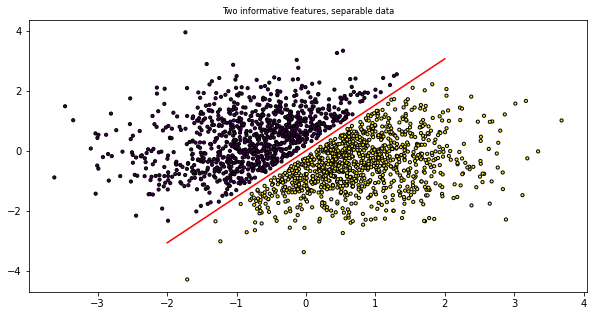

In [14]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_2000, y_2000, v_normal = make_classification_normal(2, 2000, rho=0.1)
draw_data_by_coord01(x_2000, y_2000, v_normal)

In [19]:
X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=0.33, random_state=42)

In [20]:
start = time.time()
clf2000_linear = AdaBoostLinear_v1()
result, message = clf2000_linear.fit(X_train2000, y_train2000, allow_nonseparable=True)
end = time.time()
print("Elapsed time: {}".format(end - start))
print(result, message)

Elapsed time: 61.60900020599365
True Optimization terminated successfully.


In [21]:
y_test2000_forecast = clf2000_linear.predict(X_test2000)
compute_confusion_matrix(y_test2000, y_test2000_forecast, labels=[-1, 1])

Accuracy: 0.96667
F-score: 0.96774
Precision: 0.97633
Recall: 0.95930
Accuracy (balanced): 0.96699
MCC: 0.93342


,y = -1,y = 1
a(x) = -1,308,14
a(x) = 1,8,330


In [22]:
clf2000std = AdaBoostClassifier(n_estimators=100, random_state=0)
clf2000std.fit(X_train2000, y_train2000)
y_pred2000std = clf2000std.predict(X_test2000)
compute_confusion_matrix(y_test2000, y_pred2000std, labels=[-1, 1])

Accuracy: 0.96212
F-score: 0.96350
Precision: 0.96774
Recall: 0.95930
Accuracy (balanced): 0.96225
MCC: 0.92417


,y = -1,y = 1
a(x) = -1,305,14
a(x) = 1,11,330


In [23]:
start = time.time()
clf2000v2 = AdaBoostStandardClassifier_v2(n_estimators=10)
result, history = clf2000v2.fit(X_train2000, y_train2000, trace=True)
end = time.time()

print("Elapsed time: {}".format(end - start))
print(result, len(history['error']))

Elapsed time: 212.54720759391785
iterations_exceeded 10


In [24]:
y_pred2000v2 = clf2000v2.predict(X_test2000)
compute_confusion_matrix(y_test2000, y_pred2000v2, labels=[1, -1])

Accuracy: 0.85606
F-score: 0.86563
Precision: 0.84298
Recall: 0.88953
Accuracy (balanced): 0.85458
MCC: 0.71209


,y = 1,y = -1
a(x) = 1,306,57
a(x) = -1,38,259


#### Separable data with x-data from sklearn.datasets.make_classification and y-labels from custom make_separable_labels

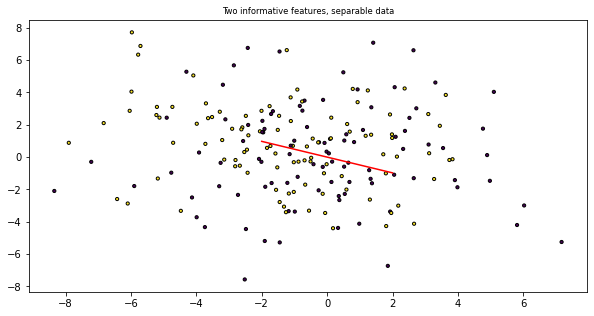

In [164]:
from sklearn.datasets import make_classification

x_1000, _ = make_classification(n_samples=200, n_features=50,n_informative=20
                                , n_redundant=20, random_state=0, n_clusters_per_class=5, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_1000, y_1000, v_normal = make_separable_labels(x_1000, rho=0.1)
draw_data_by_coord01(x_1000, y_1000, v_normal)
#print(x_1000[0:10, :], y_1000[0:10])
#print(sum(y_1000))

In [165]:
X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=0.33, random_state=42)

In [166]:
start = time.time()
clf2_linear = AdaBoostLinear_v1()
result, message = clf2_linear.fit(X_train1000, y_train1000, allow_nonseparable=True)
end = time.time()
print("Elapsed time: {}".format(end - start))
print(result, message)

Elapsed time: 2.2169857025146484
True Optimization terminated successfully.


In [167]:
y_test1000_forecast = clf2_linear.predict(X_test1000)
compute_confusion_matrix(y_test1000, y_test1000_forecast, labels=[-1, 1])

Accuracy: 0.81818
F-score: 0.82857
Precision: 0.82857
Recall: 0.82857
Accuracy (balanced): 0.81751
MCC: 0.63502


,y = -1,y = 1
a(x) = -1,25,6
a(x) = 1,6,29


In [168]:
clf2std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2std.fit(X_train1000, y_train1000)
y_pred1000std = clf2std.predict(X_test1000)
compute_confusion_matrix(y_test1000, y_pred1000std, labels=[-1, 1])

Accuracy: 0.77273
F-score: 0.78873
Precision: 0.77778
Recall: 0.80000
Accuracy (balanced): 0.77097
MCC: 0.54319


,y = -1,y = 1
a(x) = -1,23,7
a(x) = 1,8,28


In [169]:
start = time.time()
clf2v2 = AdaBoostStandardClassifier_v2(n_estimators=150)
result, history = clf2v2.fit(X_train1000, y_train1000, trace=True)
end = time.time()

print("Elapsed time: {}".format(end - start))
print(result, len(history['error']))

Elapsed time: 158.91166424751282
iterations_exceeded 150


In [170]:
y_pred1000v2 = clf2v2.predict(X_test1000)
compute_confusion_matrix(y_test1000, y_pred1000v2, labels=[-1, 1])

Accuracy: 0.84848
F-score: 0.85714
Precision: 0.85714
Recall: 0.85714
Accuracy (balanced): 0.84793
MCC: 0.69585


,y = -1,y = 1
a(x) = -1,26,5
a(x) = 1,5,30


### Breast cancer data set

In [295]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/breast-cancer/'

df = pd.read_csv(path+'breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [296]:
raw = df.to_numpy(copy=True)
x_data = raw[:, 1:10]
y_data = raw[:, 10].astype(int) - 3
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33) #, random_state=42)

#### Check if dataset is separable

In [298]:
from sklearn import svm

clf = svm.SVC(C = 10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)


1.0

In [301]:
y_pred_linear, y_pred_sklearn, y_pred_stump = get_predicts(X_train, X_test, y_train, y_test)

#### Linear ada-boost

In [302]:
res, message = compute_confusion_matrix(y_test, y_pred_linear, labels=[-1, 1])

Accuracy: 0.95671
F-score: 0.93590
Precision: 0.96053
Recall: 0.91250
Accuracy (balanced): 0.94632
MCC: 0.90393


In [303]:
print(res, message)

y = -1 y = 1


#### Decision-stump ada-boost

In [238]:
compute_confusion_matrix(y_test, y_pred_stump, labels=[-1, 1])D:\Projects-my\ml\Ml-hse-final\ada-boost-implementations\code-python\ada_boost_standard_v1.py
D:\Projects-my\ml\Ml-hse-final\ada-boost-implementations\code-python\ada_boost_linear_v1.py

Accuracy: 0.94805
F-score: 0.92500
Precision: 0.90244
Recall: 0.94872
Accuracy (balanced): 0.94822
MCC: 0.88595


,y = -1,y = 1
a(x) = -1,145,4
a(x) = 1,8,74


#### Sklearn ada-boost

In [237]:
compute_confusion_matrix(y_test, y_pred_sklearn, labels=[-1, 1])

Accuracy: 0.95671
F-score: 0.93590
Precision: 0.93590
Recall: 0.93590
Accuracy (balanced): 0.95161
MCC: 0.90322


,y = -1,y = 1
a(x) = -1,148,5
a(x) = 1,5,73


### Diabet

In [305]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/diabet/'

df = pd.read_csv(path+'diabetes.data', header=None)
df['decoded'] = df[8].apply(lambda x: -1 if x == 'tested_negative' else 1)
df.head(5)

,0,1,2,3,4,5,6,7,8,decoded
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,-1
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,-1
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1


In [306]:
y_data_df = df['decoded']
x_data_df = df.drop([8, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33) #, random_state=42)

#### Check if dataset is separable

In [308]:
from sklearn import svm

clf = svm.SVC(C=10**8)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

0.8528645833333334

In [265]:
y_pred_linear, y_pred_sklearn, y_pred_stump = get_predicts(X_train, X_test, y_train, y_test)

#### Linear ada-boost

In [266]:
compute_confusion_matrix(y_test, y_pred_linear, labels=[-1, 1])

Accuracy: 0.65354
F-score: 0.45679
Precision: 0.57812
Recall: 0.37755
Accuracy (balanced): 0.60224
MCC: 0.22927


,y = -1,y = 1
a(x) = -1,129,61
a(x) = 1,27,37


#### Decision-stump ada-boost

In [267]:
compute_confusion_matrix(y_test, y_pred_stump, labels=[-1, 1])

Accuracy: 0.76772
F-score: 0.67039
Precision: 0.74074
Recall: 0.61224
Accuracy (balanced): 0.73881
MCC: 0.49889


,y = -1,y = 1
a(x) = -1,135,38
a(x) = 1,21,60


#### Sklearn ada-boost

In [268]:
compute_confusion_matrix(y_test, y_pred_sklearn, labels=[-1, 1])

Accuracy: 0.74803
F-score: 0.64045
Precision: 0.71250
Recall: 0.58163
Accuracy (balanced): 0.71710
MCC: 0.45503


,y = -1,y = 1
a(x) = -1,133,41
a(x) = 1,23,57


### Ionosphere

In [309]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/ionosphere/'

df = pd.read_csv(path+'ionosphere.data', header=None)
df['decoded'] = df[34].apply(lambda x: -1 if x == 'b' else 1)
#df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,decoded
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b,-1
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b,-1
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g,1


In [310]:
y_data_df = df['decoded']
x_data_df = df.drop([34, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33) #, random_state=42)

#### Check if dataset is separable

In [311]:
from sklearn import svm

clf = svm.SVC(C=10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

1.0

In [282]:
y_pred_linear, y_pred_sklearn, y_pred_stump = get_predicts(X_train, X_test, y_train, y_test)

#### Linear ada-boost

In [283]:
compute_confusion_matrix(y_test, y_pred_linear, labels=[-1, 1])

Accuracy: 0.87069
F-score: 0.90066
Precision: 0.89474
Recall: 0.90667
Accuracy (balanced): 0.85577
MCC: 0.71563


,y = -1,y = 1
a(x) = -1,33,7
a(x) = 1,8,68


#### Decision-stump ada-boost

In [284]:
compute_confusion_matrix(y_test, y_pred_stump, labels=[-1, 1])

Accuracy: 0.93966
F-score: 0.95425
Precision: 0.93590
Recall: 0.97333
Accuracy (balanced): 0.92569
MCC: 0.86718


,y = -1,y = 1
a(x) = -1,36,2
a(x) = 1,5,73


#### Sklearn ada-boost

In [285]:
compute_confusion_matrix(y_test, y_pred_sklearn, labels=[-1, 1])

Accuracy: 0.93966
F-score: 0.95484
Precision: 0.92500
Recall: 0.98667
Accuracy (balanced): 0.92016
MCC: 0.86831


,y = -1,y = 1
a(x) = -1,35,1
a(x) = 1,6,74


In [287]:
def generate_data(n_samples=200, n_features=50,n_informative=20, n_redundant=20, rho=0.1):
    x_raw, _ = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative
                                   , n_redundant=n_redundant, random_state=0, n_clusters_per_class=5, shuffle=False)

    x_data, y_data, v_normal = make_separable_labels(x_raw, rho)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [288]:
def get_predicts(X_train, X_test, y_train, y_test):
    #Linear
    clfLinear = AdaBoostLinear_v1()
    result, message = clfLinear.fit(X_train, y_train, allow_nonseparable=True)
    y_pred_linear = clfLinear.predict(X_test)
    #Ada-boost sklearn
    clfSkln = AdaBoostClassifier(n_estimators=150, random_state=0)
    clfSkln.fit(X_train, y_train)
    y_pred_sklearn = clfSkln.predict(X_test)
    #Ada-boost decision-stump
    clfStd = AdaBoostStandardClassifier_v2(n_estimators=150)
    clfStd.fit(X_train, y_train, trace=True)
    y_pred_stump = clfStd.predict(X_test)
    return y_pred_linear, y_pred_sklearn, y_pred_stump

In [291]:
TESTS_COUNT=1

features_list=[25,50,75,100] #,125,150,175,200]#,225,250,275,300,325,350,375,400,425,450,475,500]
accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]

for features in features_list:
    print("processing dataset with {} features".format(features))
    n_features, n_informative, n_redundant= features, int(features*0.2), int(features*0.6)
    buff_linear, buff_sklearn, buff_stump=[], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)


processing dataset with 25 features
processing dataset with 50 features
processing dataset with 75 features
processing dataset with 100 features


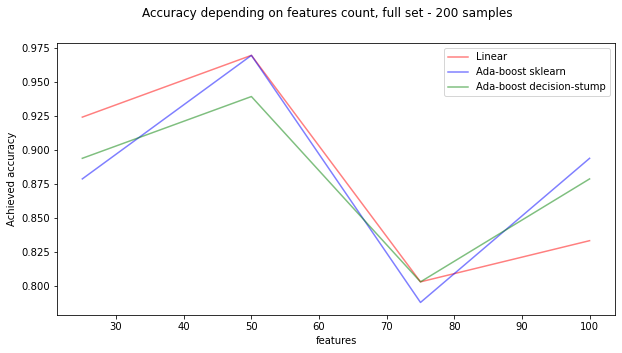

In [292]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('features')
plt.ylabel('Achieved accuracy')
plt.suptitle("Accuracy depending on features count, full set - 200 samples")

plt.plot(features_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(features_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

In [293]:
features_list=[25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]

for features in features_list:
    print("processing dataset with {} features".format(features))
    n_features, n_informative, n_redundant= features, features, 0 #int(features*0.4), int(features*0.4)
    buff_linear, buff_sklearn, buff_stump=[], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)


processing dataset with 25 features
processing dataset with 50 features
processing dataset with 75 features
processing dataset with 100 features
processing dataset with 125 features
processing dataset with 150 features
processing dataset with 175 features
processing dataset with 200 features
processing dataset with 225 features
processing dataset with 250 features
processing dataset with 275 features
processing dataset with 300 features
processing dataset with 325 features
processing dataset with 350 features
processing dataset with 375 features
processing dataset with 400 features
processing dataset with 425 features
processing dataset with 450 features
processing dataset with 475 features
processing dataset with 500 features


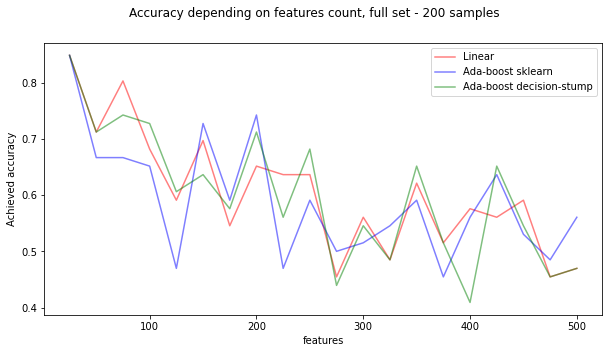

In [294]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('features')
plt.ylabel('Achieved accuracy')
plt.suptitle("Accuracy depending on features count, full set - 200 samples")

plt.plot(features_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(features_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))